In [1]:
from uncertainties import ufloat
from uncertainties.umath import *
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.stats import LombScargle
from scipy import signal
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import scipy.optimize
# from lmfit.models import GaussianModel
import glob
from astropy.table import Table,join,vstack,unique
from importlib import reload
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sb

import ogle as o #module

blue = 'cornflowerblue'
navy = 'navy'
purple = 'rebeccapurple'
pink = '#CF6275'
maroon = 'maroon'

cross = Table.read('sourcefiles.csv')
full = Table.read('smc_x_m03_zar_match_OGLE_v2.ascii',format='ascii')

# Import Wotan

In [2]:
import wotan

# Load in Example LC to Use

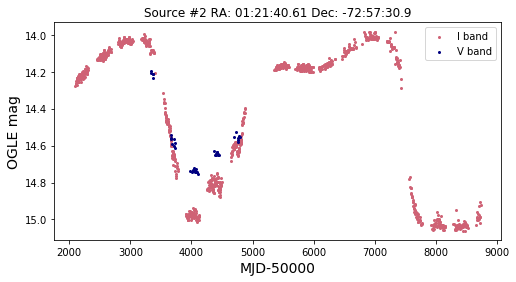

In [3]:
iband,vband = o.getIV(2,cross,plot=True,zooms=False,figsize=(8,4),mult=(3,8),offset=10,stack=True,save=False)

# Try Spline Detrending

In [4]:
#using variable names from their example below
time = iband['MJD-50000']
flux = iband['I mag']

In [5]:
flatten_lc1, trend_lc1 = wotan.flatten(
    time,                 # Array of time values
    flux,                 # Array of flux values
    method='rspline',
    window_length=200,    # The length of the filter window in units of ``time``
    break_tolerance=50,  # Split into segments at breaks longer than that
    return_trend=True,    # Return trend and flattened light curve
    )

flatten_lc2, trend_lc2 = wotan.flatten(
    time,                 # Array of time values
    flux,                 # Array of flux values
    method='hspline',
    window_length=200,    # The length of the filter window in units of ``time``
    break_tolerance=50,  # Split into segments at breaks longer than that
    return_trend=True,    # Return trend and flattened light curve
    )

flatten_lc3, trend_lc3 = wotan.flatten(
    time,                 # Array of time values
    flux,                 # Array of flux values
    method='pspline',
                          # No window length! It is automatically selected
    break_tolerance=50,  # Split into segments at breaks longer than that
    return_trend=True,    # Return trend and flattened light curve
    )

keep getting all nans for second spline, and third doesn't work very well
- could investigate further, but first working well, at least with this example

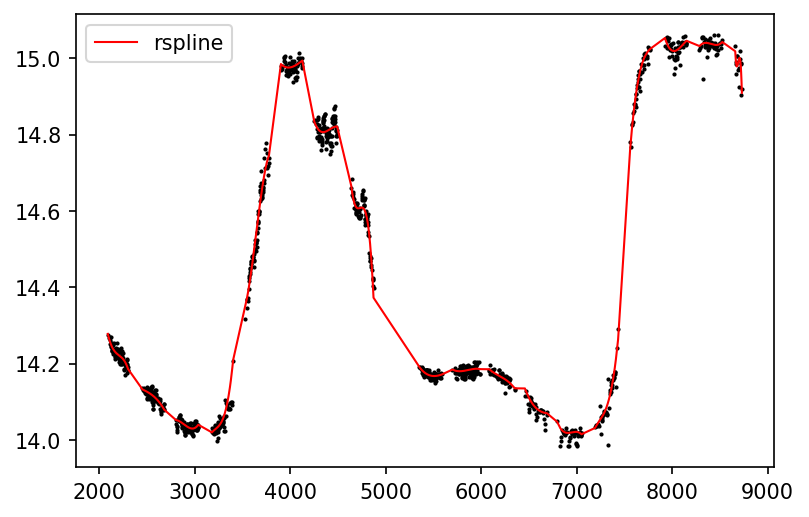

In [6]:
from matplotlib import rcParams; rcParams["figure.dpi"] = 150

plt.scatter(time, flux, s=1, color='black')
plt.plot(time, trend_lc1, color='red', linewidth=1, label='rspline')
# plt.plot(time, trend_lc2, color='blue', linewidth=1, label='hspline')
# plt.plot(time, trend_lc3, color='orange', linewidth=1, label='pspline')

plt.legend()

# plt.scatter(time, flatten_lc1, s=1, color='black');

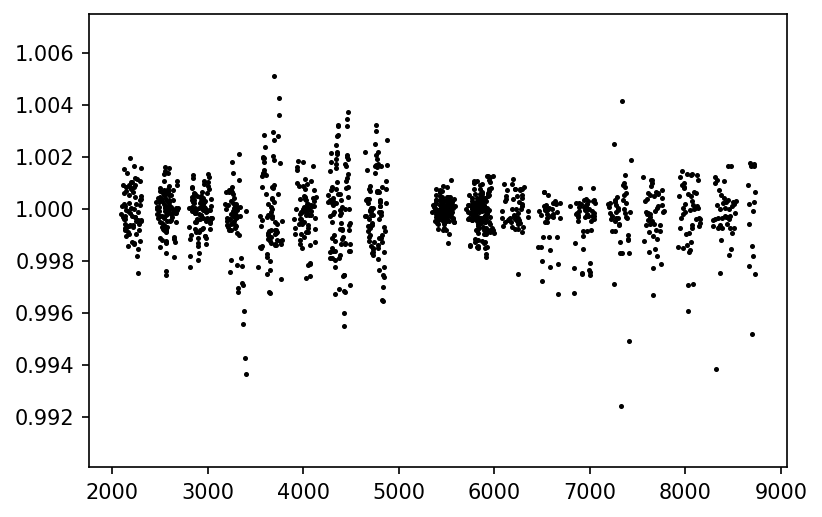

In [7]:
#plot two detrended
plt.scatter(time, flatten_lc1, color='black', s=2, label='rspline')
# plt.scatter(time, flatten_lc3, color='red', s=2, label='rspline')

In [8]:
#best way to deal with nan values?
for f in range(len(flatten_lc1)):
    if np.isnan(flatten_lc1[f]): 
        flatten_lc1[f] = 0
        print('found nan')

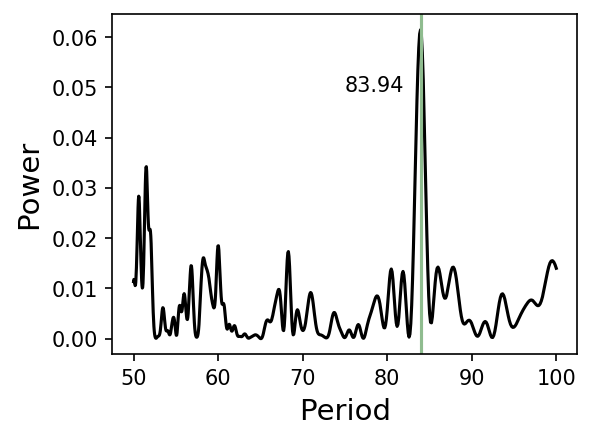

In [9]:
iband['I detrend'] = flatten_lc1
o.periodogram(iband,det=True,minp=50,maxp=100)
plt.axvline(84,color='darkseagreen')

biweight also returning nans
- can look into more, but this spline seems like a good option
- **trying on a few sources**

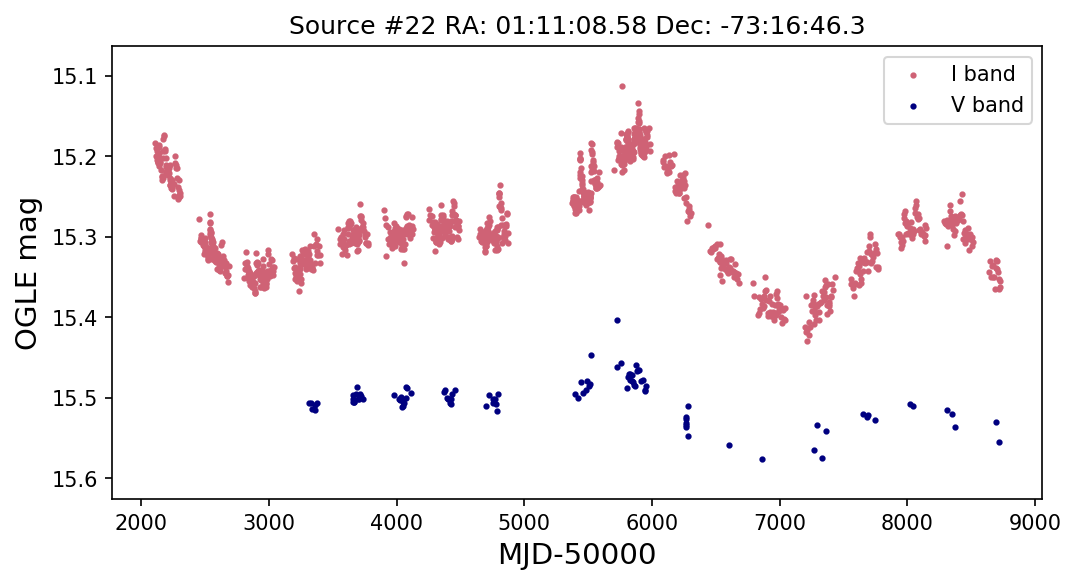

In [10]:
iband,vband = o.getIV(22,cross,plot=True,zooms=False,figsize=(8,4),mult=(3,8),offset=10,stack=True,save=False)

In [11]:
time = iband['MJD-50000']
flux = iband['I mag']

In [12]:
flatten_lc1, trend_lc1 = wotan.flatten(
    time,                 # Array of time values
    flux,                 # Array of flux values
    method='rspline',
    window_length=200,    # The length of the filter window in units of ``time``
    break_tolerance=50,  # Split into segments at breaks longer than that
    return_trend=True,    # Return trend and flattened light curve
    )

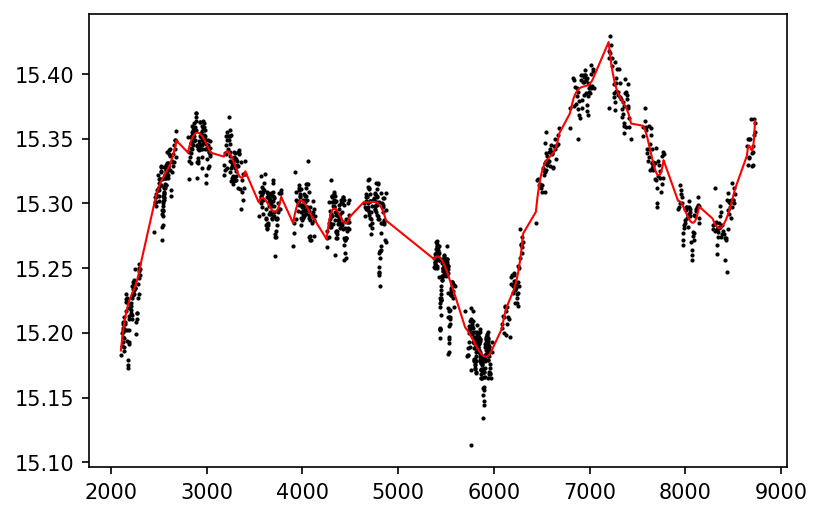

In [13]:
plt.scatter(time, flux, s=1, color='black')
plt.plot(time, trend_lc1, color='red', linewidth=1, label='rspline')

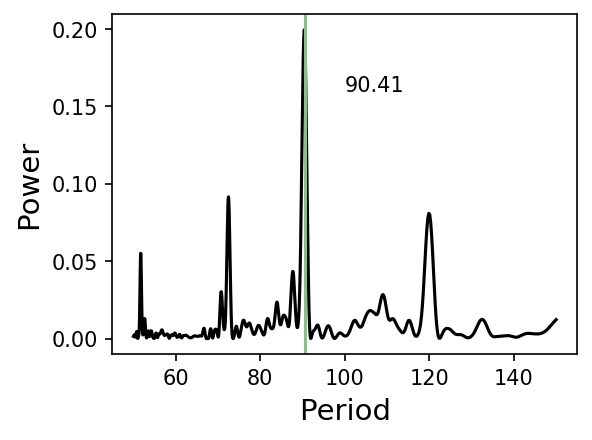

In [14]:
iband['I detrend'] = flatten_lc1
o.periodogram(iband,det=True,minp=50,maxp=150)
plt.axvline(90.5,color='darkseagreen')

In [15]:
def splinesearch(srcn,minp=5,maxp=100,window=200,btol=50):
    '''Load in light curve and plot; spline detrend, and search for orbital period'''
    #get I and V LCs and plot
    iband,vband = o.getIV(srcn,cross,plot=True,zooms=False,figsize=(8,4),mult=(3,8),offset=10,stack=True,save=False)
    row = full[full['src_n']==srcn]
    #established period
    orb = float(row['Porb'])
    print(f'established period: {orb}')
    time = iband['MJD-50000']
    flux = iband['I mag']
    #detrend with spline
    flatten_lc1, trend_lc1 = wotan.flatten(
    time,                 # Array of time values
    flux,                 # Array of flux values
    method='rspline',
    window_length=200,    # The length of the filter window in units of ``time``
    break_tolerance=50,  # Split into segments at breaks longer than that
    return_trend=True,    # Return trend and flattened light curve
    )
    #plot trend used for detrending on LC
    plt.plot(time, trend_lc1, color='red', linewidth=1, label='rspline')
    #get rid of nans
    for f in range(len(flatten_lc1)):
        if np.isnan(flatten_lc1[f]): 
            flatten_lc1[f] = 0
            print('found nan')
    #periodogram with detrended
    iband['I detrend'] = flatten_lc1
    o.periodogram(iband,det=True,minp=minp,maxp=maxp)
    plt.axvline(orb,color='darkseagreen')

established period: 82.37


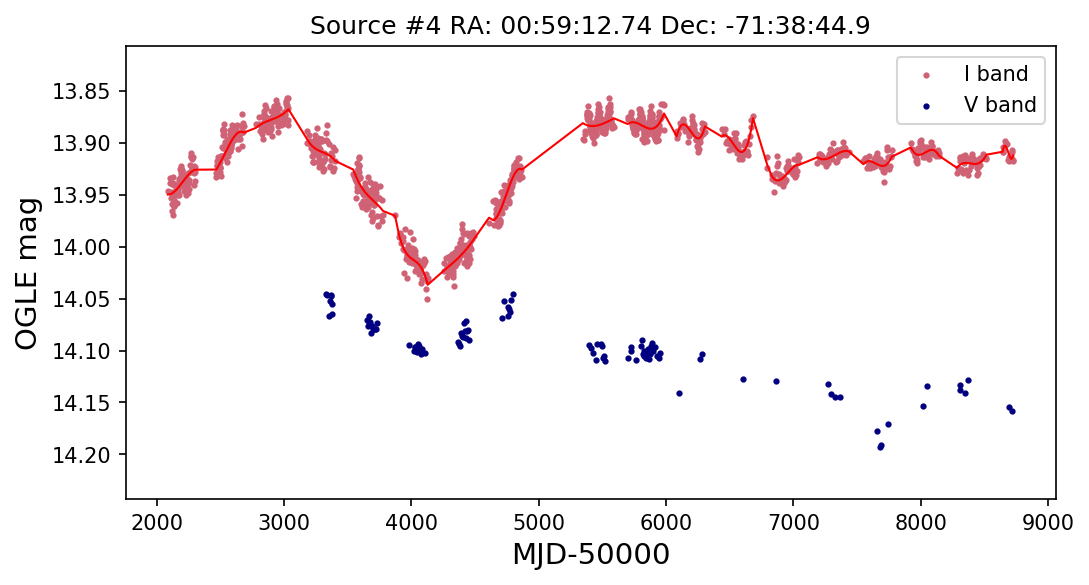

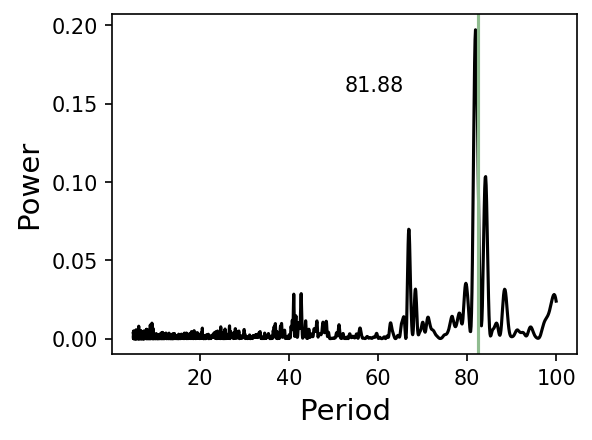

In [16]:
splinesearch(4,window=300)

established period: 103.6
found nan
found nan
found nan
found nan


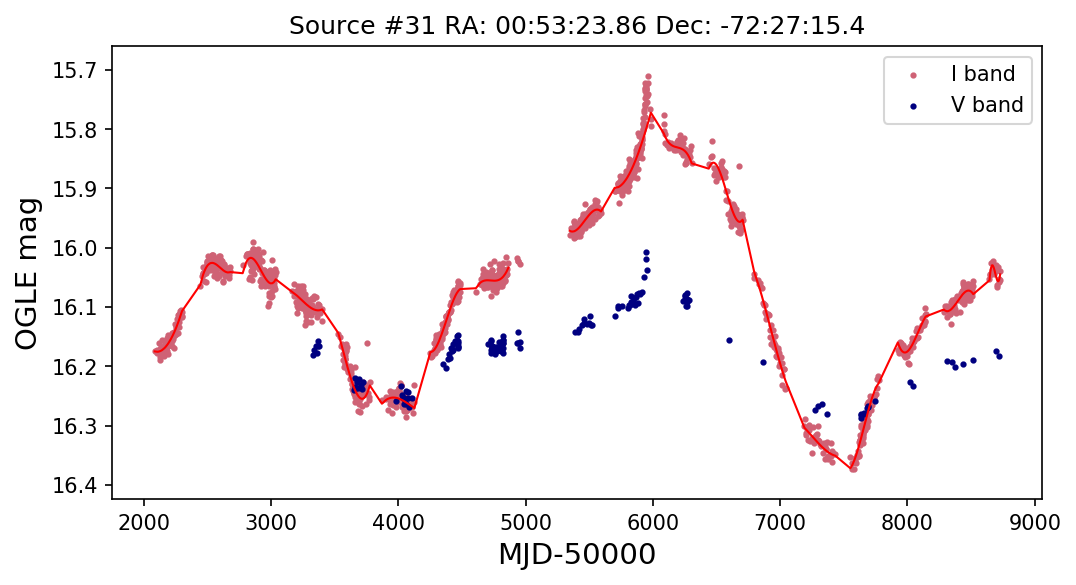

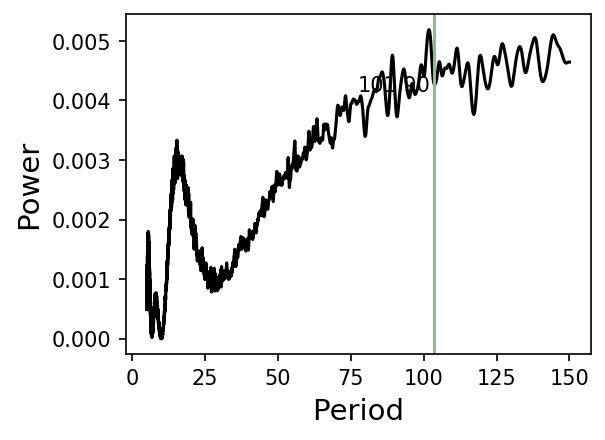

In [17]:
splinesearch(31,window=300,maxp=150)

established period: 82.37


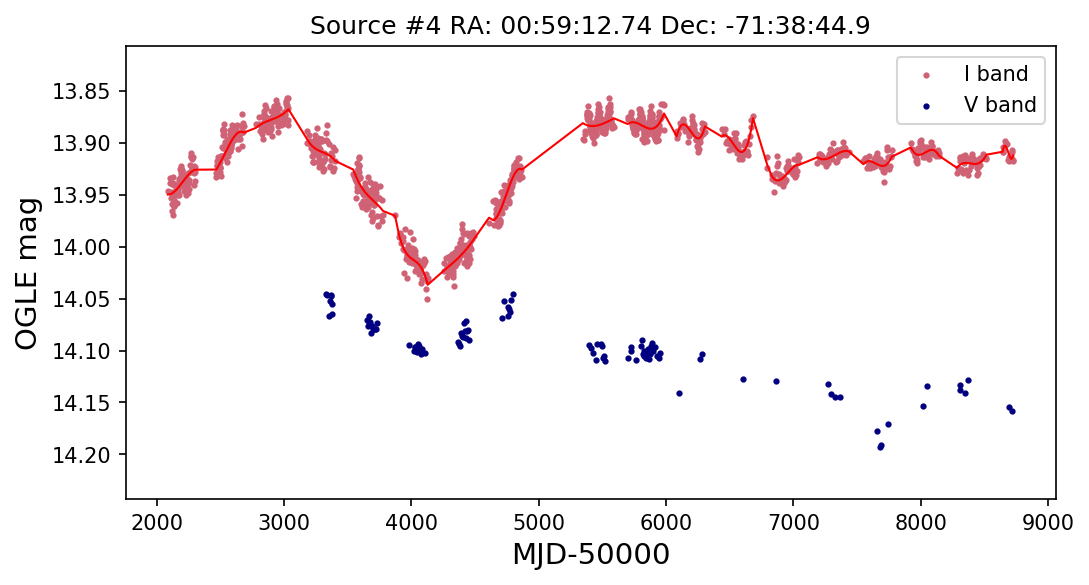

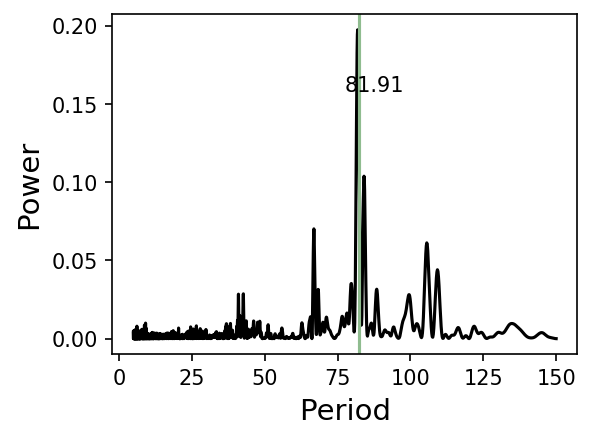

In [18]:
splinesearch(4,window=300,maxp=150)

established period: 44.92
found nan
found nan
found nan
found nan


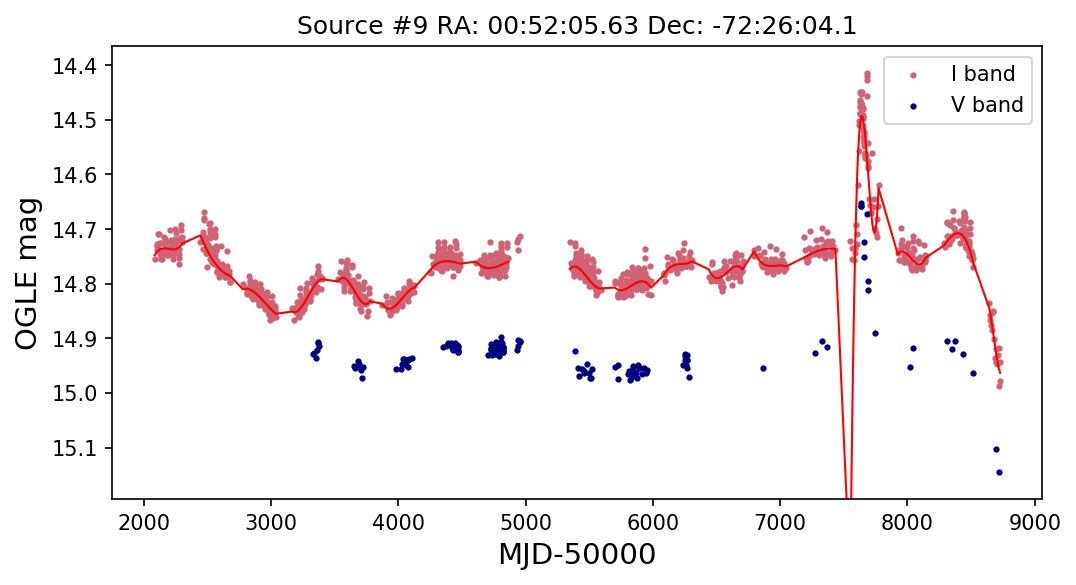

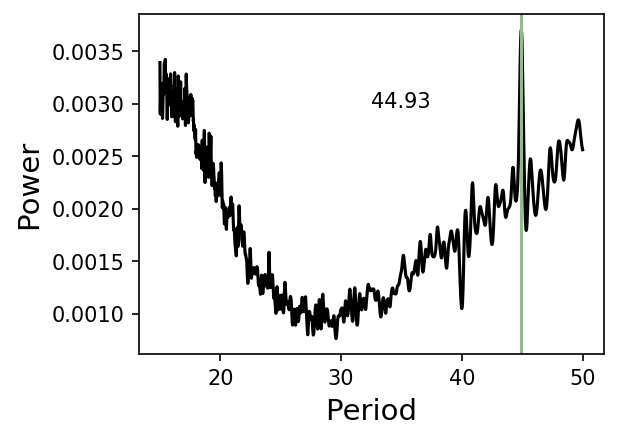

In [19]:
splinesearch(9,window=200,maxp=50,minp=15)

established period: 40.03
found nan
found nan


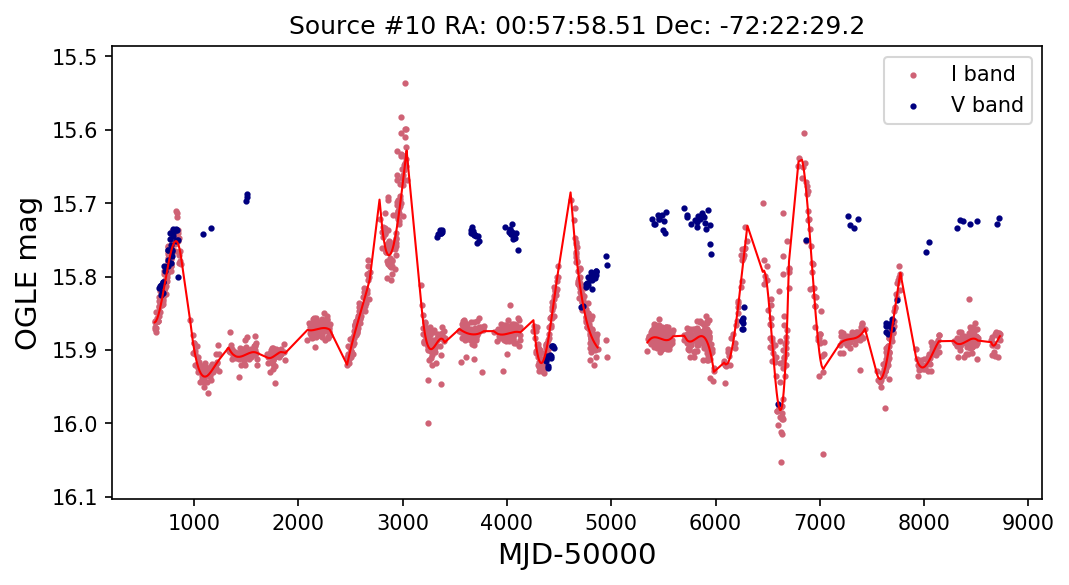

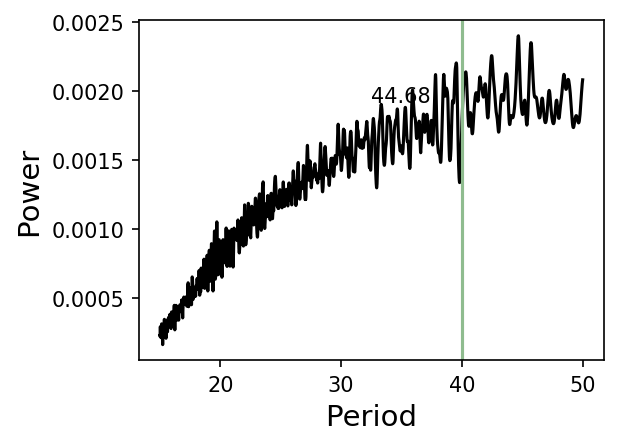

In [20]:
splinesearch(10,window=200,maxp=50,minp=15)

established period: 36.3
found nan
found nan
found nan
found nan
found nan
found nan
found nan


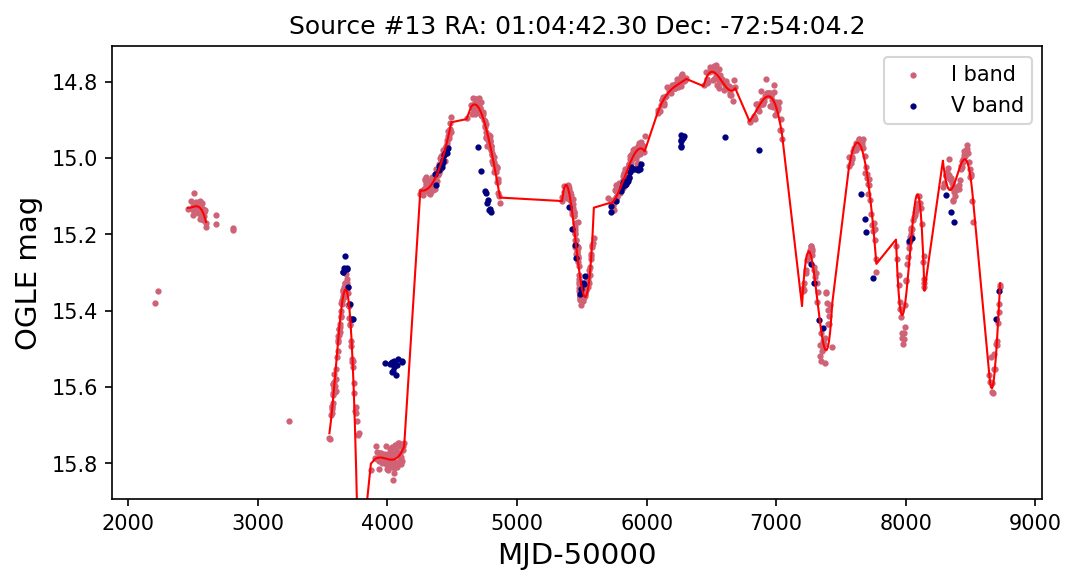

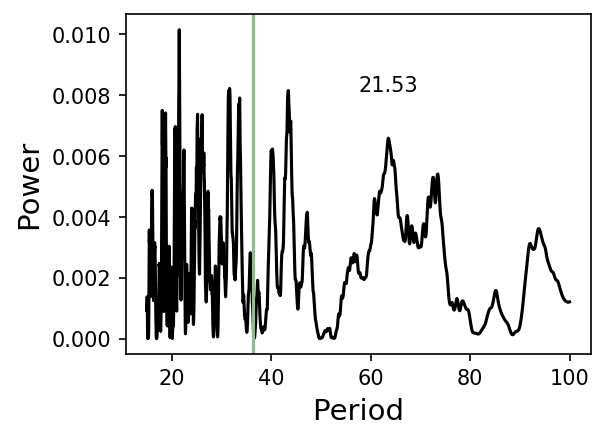

In [21]:
splinesearch(13,window=200,maxp=100,minp=15)